# Import Dependencies

In [37]:
# Import tensorflow functional API

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics


# Import useful package

import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid

In [3]:
# Extract LFW file

!tar -xf lfw.tgz

In [2]:
# Setup directory path

POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANCHOR_PATH = os.path.join('data', 'anchor')

In [ ]:
# Move LFW datasets to negative path

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [15]:
camera = cv2.VideoCapture(0)

positive_index = 0
anchor_index = 0

while camera.isOpened(): 
    ret, frame = camera.read()
   
    # Cut down frame to 250x250px
    frame = frame[:400,:400, :]
    
    image_resized = cv2.resize(frame, (250, 250))
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        anchor_index += 1
        image_name = os.path.join(ANCHOR_PATH, '{}.jpg'.format(anchor_index))
        cv2.imwrite(image_name, image_resized)
    
    if cv2.waitKey(1) & 0XFF == ord('p'):
        positive_index += 1
        image_name = os.path.join(POS_PATH, '{}.jpg'.format(positive_index))
        cv2.imwrite(image_name, image_resized)
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
camera.release()
# Close the image show frame
cv2.destroyAllWindows()

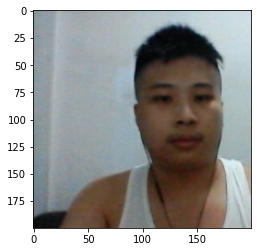

In [20]:
target_shape = (200, 200)

def preprocess_image(filename):
  image_string = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image_string, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, target_shape)
  return image


plt.imshow(preprocess_image("data\\anchor\\1.jpg"))

In [27]:
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [29]:
# Create Triplets Pair Dataset using tf.data.Dataset

anchor_images = sorted(
    [str(ANCHOR_PATH + '\\' + f) for f in os.listdir(ANCHOR_PATH)]
)

positive_images = sorted(
    [str(POS_PATH + '\\' + f) for f in os.listdir(POS_PATH)]
)

negative_images = sorted(
    [str(NEG_PATH + '\\' + f) for f in os.listdir(NEG_PATH)]
)

image_count = len(anchor_images)


anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

print(len(dataset))


190


In [32]:
# Split training dan validation dataset

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

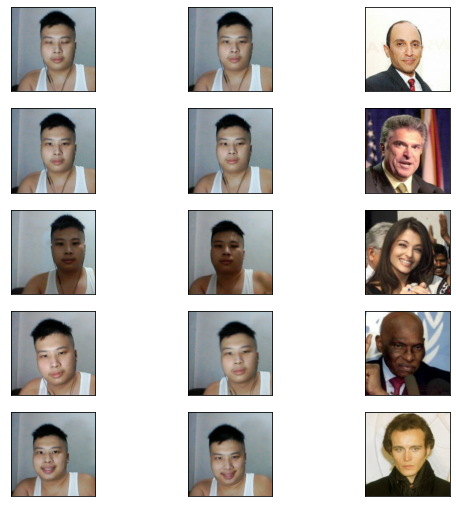

In [36]:
def visualize(anchor, positive, negative):

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(5, 3)
    for i in range(5):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [42]:
ResNetCNN = resnet.ResNet50(
  weights="imagenet", input_shape=target_shape + (3, ), include_top=False
)

Flatten = layers.Flatten()(ResNetCNN.output)
Dense1 = layers.Dense(512, activation="relu")(Flatten)
Dense1 = layers.BatchNormalization()(Dense1)
Dense2 = layers.Dense(256, activation="relu")(Dense1)
Dense2 = layers.BatchNormalization()(Dense2)
Output = layers.Dense(256)(Dense2)

trainable = False
for layer in ResNetCNN.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

Embeddings = Model(ResNetCNN.input, Output, name="Embeddings")

Embeddings.summary()

Model: "Embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
_________________________________________________________________________________________

In [43]:
class DistanceLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return (ap_distance, an_distance)

In [44]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

Distances = DistanceLayer()(
    Embeddings(resnet.preprocess_input(anchor_input)),
    Embeddings(resnet.preprocess_input(positive_input)),
    Embeddings(resnet.preprocess_input(negative_input)),
)

SiameseNetwork = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=Distances
)

In [45]:
class SiameseModel(Model):

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]


In [46]:
siamese_model = SiameseModel(SiameseNetwork)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
5/5 [==============================] - 42s 4s/step - loss: 0.0062 - val_loss: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 11s 2s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 12s 2s/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 12s 2s/step - loss: 0.0172 - val_loss: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 11s 2s/step - loss: 0.0220 - val_loss: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 11s 2s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 11s 2s/step - loss: 0.0429 - val_loss: 0.0113
Epoch 8/10
5/5 [==============================] - 12s 2s/step - loss: 0.0329 - val_loss: 0.0000e+00
Epoch 9/10
5/5 [==============================] - 12s 2s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/10
5/5 [==============================] - 12s 2s/step - loss: 0.0064 - val_loss: 0.

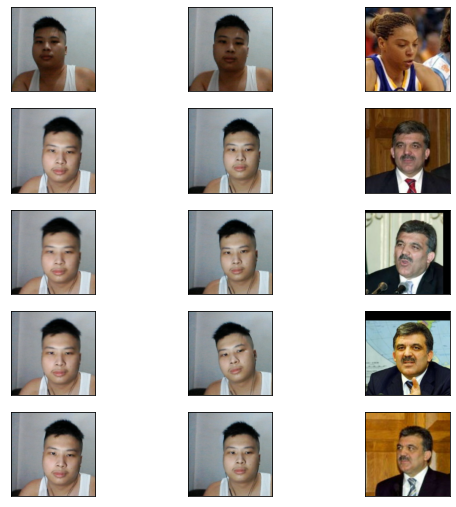

In [76]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    Embeddings(resnet.preprocess_input(anchor)),
    Embeddings(resnet.preprocess_input(positive)),
    Embeddings(resnet.preprocess_input(negative)),
)

In [131]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9998057
Negative similarity 0.9945618


In [132]:
anchor_image = preprocess_image('./data/anchor/1.jpg')
input_image = preprocess_image('./data/positive/89.jpg')
negative_image = preprocess_image('./data/negative/Aaron_Tippin_0001.jpg')

anchor_image_embedding = Embeddings(anchor_image[None, :, :, :])
postive_image_embedding = Embeddings(input_image[None, :, :, :])
negative_image_embedding = Embeddings(negative_image[None, :, :, :])

cosine_similarity.reset_state()

positive_similarity = cosine_similarity(anchor_image_embedding, postive_image_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_image_embedding, negative_image_embedding)
print("Negative similarity", negative_similarity.numpy())

ap_distance = tf.reduce_sum(tf.square(anchor_image_embedding - postive_image_embedding), axis=-1)
an_distance = tf.reduce_sum(tf.square(anchor_image_embedding - negative_image_embedding), axis=-1)

print(ap_distance)
print(an_distance)

Positive similarity: 0.99985003
Negative similarity 0.99924725
tf.Tensor([1.8735971], shape=(1,), dtype=float32)
tf.Tensor([15.863497], shape=(1,), dtype=float32)
